<a href="https://colab.research.google.com/github/microprediction/timeseries-notebooks/blob/main/pytorch_fractional_differencer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch

In [4]:
import torch
import numpy as np
from scipy.special import comb
import numpy as np
import matplotlib.pyplot as plt


class TorchFractionalDifferentiator:

    def __init__(self, order, memory_threshold=1e-4, max_lags=20, verbose=False):
        self.order = order
        self.verbose = verbose
        self.memory_threshold = memory_threshold
        self.max_lags = max_lags
        self.num_lags = len(self._get_memory_weights(order, memory_threshold=self.memory_threshold, max_lags=max_lags)) - 1

    def _get_memory_weights(self, order, memory_threshold, max_lags):
        memory_weights = [1,]
        k = 1
        while True:
            weight = -memory_weights[-1] * (order - k + 1) / k
            if (abs(weight) < memory_threshold) or len(memory_weights)>max_lags:
                if self.verbose:
                  print({'len(memory_weights)':len(memory_weights)})
                break
            memory_weights.append(weight)
            k += 1
        return np.array(list(reversed(memory_weights)))

    def transform(self, data_tensor):
        data_np = data_tensor.numpy()
        frac_diffed = self._frac_diff(data_np, order=self.order)
        return torch.tensor(frac_diffed)

    def _frac_diff(self, ts, order=1, memory_weights=None):
        if memory_weights is None:
            memory_weights = self._get_memory_weights(order, memory_threshold=self.memory_threshold, max_lags=self.max_lags)

        K = len(memory_weights)
        frac_diffed_series = np.array([np.sum(ts[i - K:i] * memory_weights) for i in range(K, len(ts) + 1)])
        return frac_diffed_series

    def inverse_transform_attempt(self, frac_diffed_tensor, lag_data_tensor):
        if frac_diffed_tensor.shape[0] != lag_data_tensor.shape[0]:
            raise Exception(f'frac_diffed_tensor and lag_data_tensor should have the same number of elements.')

        if lag_data_tensor.shape[0] < self.num_lags:
            raise Exception(f'The previous {self.num_lags} values are required.')

        frac_diffed_np = frac_diffed_tensor.detach().numpy()
        memory_weights = self._get_memory_weights(self.order, memory_threshold=self.memory_threshold, max_lags=self.max_lags)
        K = self.num_lags

        res = np.zeros(frac_diffed_np.shape)
        for t in range(res.shape[0]):
            res[t] = frac_diffed_np[t] + np.sum(memory_weights[:t+1] * np.flip(lag_data_tensor[-t-1:].detach().numpy()))

        return torch.tensor(res, dtype=torch.float32)

    def inverse_transform(self, frac_diffed_tensor, lag_data_tensor):
        if lag_data_tensor.shape[0] != self.num_lags:
            raise Exception(f'The previous {self.num_lags} values are required.')

        memory_weights = self._get_memory_weights(self.order, memory_threshold=self.memory_threshold, max_lags=self.max_lags)
        memory_weights_tensor = torch.tensor(memory_weights, dtype=torch.float32)
        K = self.num_lags

        ts_lag_data = lag_data_tensor[:K]
        x_tilde = frac_diffed_tensor[K:]
        if K == 0:
            return x_tilde

        x_vals = ts_lag_data.clone()
        for t in range(x_tilde.shape[0]):
            x_current = x_tilde[t] - torch.sum(memory_weights_tensor[:-1] * x_vals[-K:])
            x_vals = torch.cat((x_vals, x_current.unsqueeze(0)), dim=0)

        return torch.tensor(x_vals).float()


{'num_lags': 20}


<ipython-input-4-6c4dbc5886f8>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_vals).float()


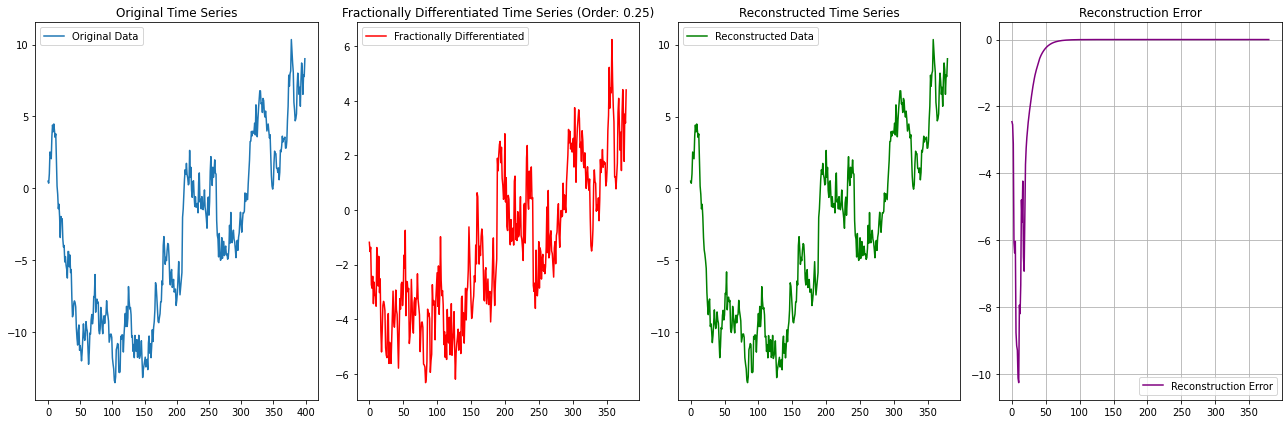

In [5]:


# Generate a synthetic time series
np.random.seed(42)
n = 400
original_data = np.cumsum(np.random.randn(n))

# Set the fractional differentiation order
order = 0.25

# Create a TorchFractionalDifferentiator object
torch_frac_diff = TorchFractionalDifferentiator(order, memory_threshold=1e-5, max_lags=20)
print({'num_lags': torch_frac_diff.num_lags})

# Transform the data (fractional differentiation)
original_data_tensor = torch.tensor(original_data, dtype=torch.float32)
frac_diffed_tensor = torch_frac_diff.transform(original_data_tensor)

# Inverse transform (fractional integration)
lag_data_tensor = original_data_tensor[:torch_frac_diff.num_lags]
reconstructed_tensor = torch_frac_diff.inverse_transform(frac_diffed_tensor, lag_data_tensor)

# Convert tensors to numpy arrays for plotting
frac_diffed_data = frac_diffed_tensor.numpy()
reconstructed_data = reconstructed_tensor.numpy()

# Calculate the reconstruction error
reconstruction_error = original_data[torch_frac_diff.num_lags:] - reconstructed_data

# Plot the original, fractionally differentiated, reconstructed time series, and reconstruction error
plt.figure(figsize=(18, 6))

plt.subplot(141)
plt.plot(original_data, label='Original Data')
plt.title('Original Time Series')
plt.legend()

plt.subplot(142)
plt.plot(frac_diffed_data, label='Fractionally Differentiated', color='red')
plt.title(f'Fractionally Differentiated Time Series (Order: {order})')
plt.legend()

plt.subplot(143)
plt.plot(reconstructed_data, label='Reconstructed Data', color='green')
plt.title('Reconstructed Time Series')
plt.legend()

plt.subplot(144)
plt.plot(reconstruction_error, label='Reconstruction Error', color='purple')
plt.title('Reconstruction Error')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
frac_diffed_data

In [ ]:
original_data[-1]-original_data[-10], reconstructed_data[-1]-reconstructed_data[-10]

(-0.45312338843556166, 2.080732653194806)

In [ ]:
from torch import nn, optim
class TimeSeriesPredictor(nn.Module):
    def __init__(self, order, max_lags, k):
        super(TimeSeriesPredictor, self).__init__()
        self.order = order
        self.max_lags = max_lags
        self.k = k

        self.lstm_a = nn.LSTM(input_size=1, hidden_size=1, num_layers=1, batch_first=True)
        self.lstm_b = nn.LSTM(input_size=1, hidden_size=1, num_layers=1, batch_first=True)

        self.torch_frac_diff = TorchFractionalDifferentiator(order=self.order, max_lags=self.max_lags)

    def forward(self, x):
        _, (h_n_a, _) = self.lstm_a(x)

        y_hat = h_n_a.repeat(self.k, 1, 1)
        y_hat = y_hat.permute(1, 0, 2)
        concat_x_y_hat = torch.cat((x, y_hat), dim=1)
        _, (h_n_b, _) = self.lstm_b(concat_x_y_hat)
        y_prime_hat = self.torch_frac_diff.inverse_transform(h_n_b.squeeze(), x[:self.max_lags].squeeze())
        return torch.cat((y_hat.squeeze(), y_prime_hat.unsqueeze(-1)), dim=1)


In [ ]:
# Generate realistic training data

# Prepare training data
batch_size = 100  # Increase the batch size for more training data
n = 400
order = 0.5
k = 5
max_lags=20

def generate_realistic_data(n, order, frac_diff, k):
    random_data = torch.randn(n + k, 1).float()
    cumsum_data = torch.cumsum(random_data, dim=0)
    y_transformed = frac_diff.transform(cumsum_data)[-k:].unsqueeze(-1).float()
    x_data = cumsum_data[:-k].float()
    y_data = torch.cat((cumsum_data[-k:], y_transformed), dim=0).float()
    return x_data, y_data

torch_frac_diff = TorchFractionalDifferentiator(order=order, max_lags=max_lags)

x_data = []
y_combined_data = []
for _ in range(batch_size):
    x, y = generate_realistic_data(n, order, torch_frac_diff, k)
    x_data.append(x)
    y_combined_data.append(y)

x_tensor = torch.stack(x_data)
y_combined_tensor = torch.stack(y_combined_data)


# Initialize the model, loss function, and optimizer
model = TimeSeriesPredictor(order=order, max_lags=max_lags, k=k)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training
epochs = 10000

for epoch in range(epochs):
    total_loss = 0
    for i in range(batch_size):
        optimizer.zero_grad()

        x_batch = x_tensor[i].unsqueeze(1)
        y_combined_batch = y_combined_tensor[i]

        y_pred_and_prime = model(x_batch).squeeze()
        y_pred = y_pred_and_prime[:k]
        y_prime = y_pred_and_prime[-k:]

        #loss = criterion(y_pred, y_combined_batch[:k]) + criterion(y_prime, y_combined_batch[k:])
        total_loss += loss.item()

        if False:
            print("y_pred dtype:", y_pred.dtype)
            print("y_combined_batch[:k] dtype:", y_combined_batch[:k].dtype)
            print("y_prime dtype:", y_prime.dtype)
            print("y_combined_batch[k:] dtype:", y_combined_batch[k:].dtype)

        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1}, Loss: {total_loss / batch_size}")



<ipython-input-191-38f96bfbd11c>:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_vals).float()


RuntimeError: ignored